# Calibration of the camera

Calibrating the left camera...
Calibrating the right camera...
Undistorting the images...
Left Camera Reprojection Error: 0.0658819284793125
Right Camera Reprojection Error: 0.0840205684669142


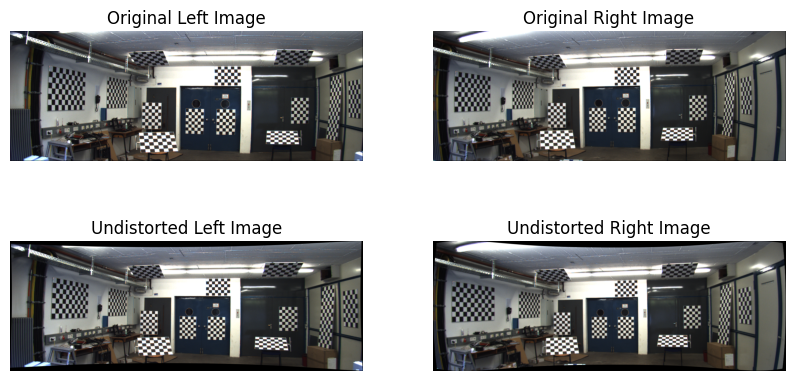

Calibrating the stereo camera...
Rectifying the stereo camera...
Computing rectification maps...
Corrected map1_left range: min=-2451440640.0, max=348.0978088378906
Corrected map2_left range: min=-476053952.0, max=424758400.0
Image shape: (512, 1392, 3)
Map1 shape: (512, 1392), Map2 shape: (512, 1392)


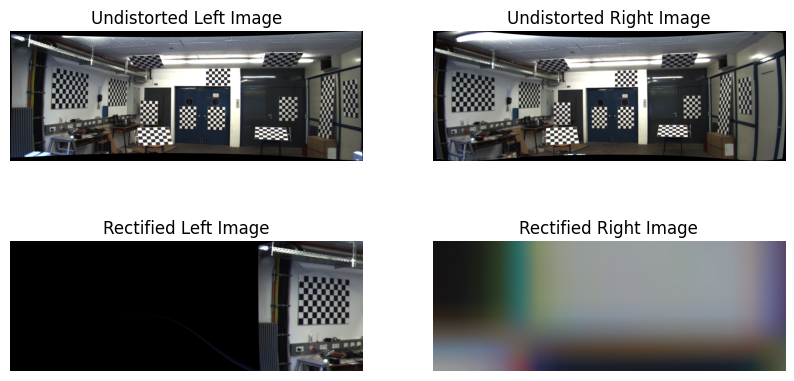

In [7]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

def preprocess_image(gray, alpha=1, beta=20, block_size=21, C=8):
    """
    Preprocess the grayscale image for better chessboard detection.
    """
    # Histogram Equalization
    gray_eq = cv2.equalizeHist(gray)

    # Contrast and Brightness Adjustment
    gray_adjusted = cv2.convertScaleAbs(gray_eq, alpha=alpha, beta=beta)

    # Adaptive Thresholding
    gray_thresh = cv2.adaptiveThreshold(gray_adjusted, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, block_size, C)

    #cv2.imshow("Preprocessed", gray_thresh)

    return gray_thresh

def ensure_2d_map(map_data):
    """
    Ensures the map data is 2D. If it has more than 2 dimensions,
    extracts the first channel (:,:,0).
    
    Parameters:
        map_data (numpy.ndarray): The map data to check.
        
    Returns:
        numpy.ndarray: The ensured 2D map.
    """
    if map_data.ndim == 2:
        return map_data  # Already 2D
    elif map_data.ndim == 3:
        return map_data[:, :, 0]  # Extract the first channel
    else:
        raise ValueError(f"Unexpected map data dimensions: {map_data.ndim}. Expected 2D or 3D.")


def detect_chessboards(img, gray, objpoints, imgpoints, roi_coords=None, idx=0, isLeft=True):
    # Copy of the image to draw the detected corners
    img_with_corners = img.copy()

    x1, y1, x2, y2 = roi_coords
    roi_gray = gray[y1:y2, x1:x2]  # Crop the grayscale image to ROI

    # Draw the ROI rectangle on the original image
    cv2.rectangle(img_with_corners, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Define chessboard sizes
    chessboard_sizes = [(5, 7), (7, 11), (6, 10), (5, 15)]  # columns, rows (15, 5) left out beacause it cannot be detected from right camera

    # Prepare object points for each chessboard size
    objp_dict = {}
    for (nx, ny) in chessboard_sizes:
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        objp_dict[(nx, ny)] = objp  # Store the objp for each size

    # Process each chessboard size
    for (nx, ny) in chessboard_sizes:
        # Detect chessboard corners in the roi
        ret, corners = cv2.findChessboardCorners(roi_gray, (nx, ny), None)
        if ret:
            # Adjust detected corners to original image coordinates
            corners_original = corners + np.array([[x1, y1]], dtype=np.float32)
        
            if (idx == 6) and isLeft == False:
                # Flip  the order of the corners_original
                #print("Flipping the corners")
                corners_original = corners_original[::-1]
            
            # Append the object points and image points
            objpoints.append(objp_dict[(nx, ny)])
            imgpoints.append(corners_original)
            
            # Draw the detected chessboard corners in the original image
            cv2.drawChessboardCorners(img_with_corners, (nx, ny), corners_original, ret)

            # Cover the detected chessboard area with black color
            cv2.fillPoly(gray, [np.int32(corners)], 0)

    #plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    #plt.show()
    return objpoints, imgpoints

# Read the images
images_left = glob.glob('34759_final_project_raw/calib/image_02/data/*.png')
images_right = glob.glob('34759_final_project_raw/calib/image_03/data/*.png')

# Arrays to store object points and image points from all the detected chessboards
objpoints_left = []     # Object points in the 3D world space
imgpoints_left = []     # Image points in the 2D image space
objpoints_right = []
imgpoints_right = []

image_left = cv2.imread(images_left[8])
image_right = cv2.imread(images_right[8])

gray_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
gray_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)

# Define ROI coordinates for each chessboard for both images
rois = [
    {"left": (300, 100, 550, 380), "right": (280, 100, 450, 380)},
    #{"left": (130, 116, 298, 316), "right": (63, 143, 247, 330)},
    {"left": (509, 269, 597, 388), "right": (433, 267, 529, 381)},
    {"left": (491, 386, 675, 485), "right": (406, 379, 570, 470)},
    {"left": (673, 285, 772, 410), "right": (597, 294, 687, 397)},
    {"left": (779, 298, 886, 410), "right": (716, 291, 806, 400)},
    {"left": (792, 123, 920, 224), "right": (700, 100, 830, 220)},
    {"left": (1000, 42, 1200, 143), "right": (885, 42, 1070, 140)},
    {"left": (1100, 250, 1200, 380), "right": (990, 230, 1090, 350)},
    {"left": (1317, 184, 1390, 385), "right": (1200, 168, 1280, 350)},
    #{"left": (1215, 163, 1323, 446), "right": (1115, 142, 1220, 445)},
    #{"left": (1000, 380, 1150, 450), "right": (880, 360, 1040, 450)},
]

# Detecting chessboards in a loop based on manually defined ROIs
for idx, roi_pair in enumerate(rois, start=1):
    #print(f"Chessboard {idx}")
    roi_left = roi_pair["left"]
    roi_right = roi_pair["right"]
    
    # Detect chessboard in left image
    if idx == 1 or idx == 9:
        objpoints_left, imgpoints_left = detect_chessboards(image_left, gray_left, objpoints_left, imgpoints_left, roi_left, idx)
    else:
        objpoints_left, imgpoints_left = detect_chessboards(
            image_left, preprocess_image(cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)), objpoints_left, imgpoints_left, roi_left, idx
        )

    # Detect chessboard in right image
    objpoints_right, imgpoints_right = detect_chessboards(
        image_right, preprocess_image(cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)), objpoints_right, imgpoints_right, roi_right, idx, isLeft=False    
    )

   # print(f"Number of left camera object points: {len(objpoints_left)}")
    #print(f"Number of right camera object points: {len(objpoints_right)}")
    #print(f"Number of left camera image points: {len(imgpoints_left)}")
    #print(f"Number of right camera image points: {len(imgpoints_right)}")

# Calibrate the cameras using collected points
print("Calibrating the left camera...")
ret_left, camera_matrix_left, dist_coeffs_left, rvecs_l, tvecs_l = cv2.calibrateCamera(objpoints_left, imgpoints_left, gray_left.shape[::-1], None, None)
print("Calibrating the right camera...")
ret_right, camera_matrix_right, dist_coeffs_right, rvecs_r, tvecs_r = cv2.calibrateCamera(objpoints_left, imgpoints_right, gray_right.shape[::-1], None, None)

# Use cv2.getOptimalNewCameraMatrix() to get the new camera matrix
new_camera_matrix_left, roi_left = cv2.getOptimalNewCameraMatrix(camera_matrix_left, dist_coeffs_left, gray_left.shape[::-1], 1, gray_left.shape[::-1])
new_camera_matrix_right, roi_right = cv2.getOptimalNewCameraMatrix(camera_matrix_right, dist_coeffs_right, gray_right.shape[::-1], 1, gray_right.shape[::-1])

# Undistort the images
print("Undistorting the images...")
undistorted_img_left = cv2.undistort(image_left, camera_matrix_left, dist_coeffs_left, None, new_camera_matrix_left)
undistorted_img_right = cv2.undistort(image_right, camera_matrix_right, dist_coeffs_right, None, new_camera_matrix_right)

## compute the reprojection error to understand if the parameters are estimated well
total_error_left = 0
for i in range(len(objpoints_left)):
    imgpoints2, _ = cv2.projectPoints(objpoints_left[i], rvecs_l[i], tvecs_l[i], camera_matrix_left, dist_coeffs_left)
    error = cv2.norm(imgpoints_left[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    total_error_left += error
print(f"Left Camera Reprojection Error: {total_error_left / len(objpoints_left)}")

total_error_right = 0
for i in range(len(objpoints_right)):
    imgpoints2, _ = cv2.projectPoints(objpoints_right[i], rvecs_r[i], tvecs_r[i], camera_matrix_right, dist_coeffs_right)
    error = cv2.norm(imgpoints_right[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    total_error_right += error
print(f"Right Camera Reprojection Error: {total_error_right / len(objpoints_right)}")

# Display the undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.imshow(cv2.cvtColor(image_left, cv2.COLOR_BGR2RGB))
plt.title("Original Left Image")
plt.axis("off")
plt.subplot(222)
plt.imshow(cv2.cvtColor(image_right, cv2.COLOR_BGR2RGB))
plt.title("Original Right Image")
plt.axis("off")
plt.subplot(223)
plt.imshow(cv2.cvtColor(undistorted_img_left, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Left Image")
plt.axis("off")
plt.subplot(224)
plt.imshow(cv2.cvtColor(undistorted_img_right, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Right Image")
plt.axis("off")
plt.show()


# Stereo calibration to find the rotation matrix and translation vector
print("Calibrating the stereo camera...")
img_shape = image_left.shape[:2][::-1]
ret_stereo, camera_matrix_left, dist_coeffs_left, camera_matrix_right, dist_coeffs_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints_right, imgpoints_left, imgpoints_right,
    camera_matrix_left, dist_coeffs_left,
    camera_matrix_right, dist_coeffs_right,
    img_shape,
    #flags=cv2.CALIB_FIX_INTRINSIC | cv2.CALIB_ZERO_TANGENT_DIST | cv2.CALIB_SAME_FOCAL_LENGTH
)

if not ret_stereo:
    print("Stereo calibration failed. Check input points.")

# Stereo rectification
print("Rectifying the stereo camera...")
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    camera_matrix_left, dist_coeffs_left,
    camera_matrix_right, dist_coeffs_right,
    img_shape, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=1.0
)

#P1[0, 2] = undistorted_img_left.shape[1] / 2  # Set cx to the center of the image width
#P1[1, 2] = undistorted_img_left.shape[0] / 2  # Set cy to the center of the image height

P1 = camera_matrix_left.copy()
P1[0, 2] = undistorted_img_left.shape[1] / 2  # Adjust `cx`
P1[1, 2] = undistorted_img_left.shape[0] / 2  # Adjust `cy`

# Compute rectification maps
print("Computing rectification maps...")
map1_left, map2_left = cv2.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_left, R1, P1, img_shape, cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_right, R2, P2, img_shape, cv2.CV_32FC1)

# to get sure that the dimension is 2d
map1_left = ensure_2d_map(map1_left)
map2_left = ensure_2d_map(map2_left)
map1_right = ensure_2d_map(map1_right)
map2_right = ensure_2d_map(map2_right)

print(f"Corrected map1_left range: min={map1_left.min()}, max={map1_left.max()}")
print(f"Corrected map2_left range: min={map2_left.min()}, max={map2_left.max()}")
# map1_left should be within [0, width-1], where width = 1392.
# map2_left should be within [0, height-1], where height = 512.

map1_left = np.clip(map1_left, 0, undistorted_img_left.shape[1] - 1)
map2_left = np.clip(map2_left, 0, undistorted_img_left.shape[0] - 1)

print(f"Image shape: {undistorted_img_left.shape}")
print(f"Map1 shape: {map1_left.shape}, Map2 shape: {map2_left.shape}")
#Both map1_left and map2_left must have the same height and width as undistorted_img_left.

rectified_img_left = cv2.remap(undistorted_img_left, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_img_right = cv2.remap(undistorted_img_right, map1_right, map2_right, cv2.INTER_LINEAR)

# Display rectified images
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.imshow(cv2.cvtColor(undistorted_img_left, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Left Image")
plt.axis("off")
plt.subplot(222)
plt.imshow(cv2.cvtColor(undistorted_img_right, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Right Image")
plt.axis("off")
plt.subplot(223)
plt.imshow(cv2.cvtColor(rectified_img_left, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image")
plt.axis("off")
plt.subplot(224)
plt.imshow(cv2.cvtColor(rectified_img_right, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image")
plt.axis("off")
plt.show()


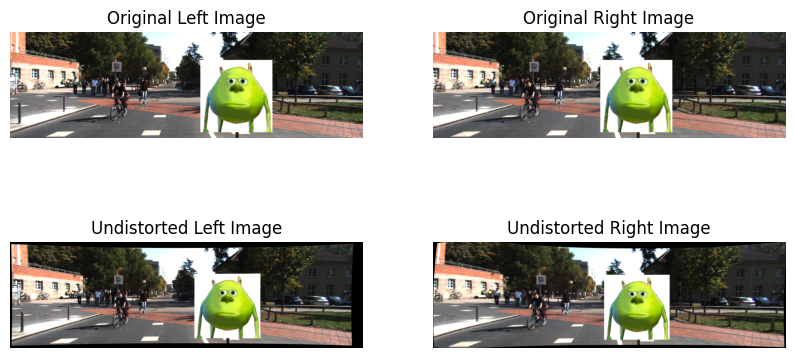

Calibrating the stereo camera...
Rectifying the stereo camera...
Computing rectification maps...
Rectifying the test images...


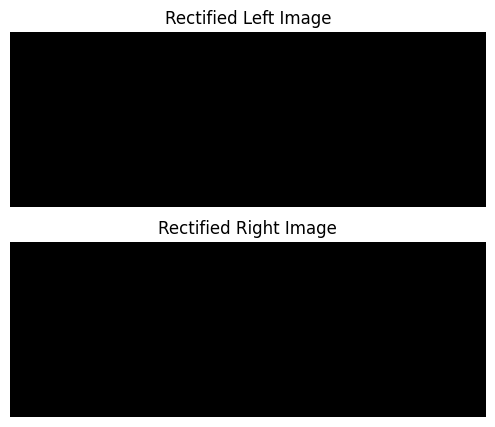

In [10]:
# application of the rectification
path = "34759_final_project_rect/seq_02/image_02/data/0000000000.png"
img_raw_left = cv2.imread(path)
path = "34759_final_project_rect/seq_02/image_03/data/0000000000.png"
img_raw_right = cv2.imread(path)

undistorted_img_left = cv2.undistort(img_raw_left, camera_matrix_left, dist_coeffs_left, None, new_camera_matrix_left)
undistorted_img_right = cv2.undistort(img_raw_right, camera_matrix_right, dist_coeffs_right, None, new_camera_matrix_right)

# Display the undistorted images
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.imshow(cv2.cvtColor(img_raw_left, cv2.COLOR_BGR2RGB))
plt.title("Original Left Image")
plt.axis("off")
plt.subplot(222)
plt.imshow(cv2.cvtColor(img_raw_right, cv2.COLOR_BGR2RGB))
plt.title("Original Right Image")
plt.axis("off")
plt.subplot(223)
plt.imshow(cv2.cvtColor(undistorted_img_left, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Left Image")
plt.axis("off")
plt.subplot(224)
plt.imshow(cv2.cvtColor(undistorted_img_right, cv2.COLOR_BGR2RGB))
plt.title("Undistorted Right Image")
plt.axis("off")
plt.show()

print("Calibrating the stereo camera...")
img_shape = image_left.shape[:2][::-1]
ret_stereo, camera_matrix_left, dist_coeffs_left, camera_matrix_right, dist_coeffs_right, R, T, E, F = cv2.stereoCalibrate(
    objpoints_right, imgpoints_left, imgpoints_right,
    camera_matrix_left, dist_coeffs_left,
    camera_matrix_right, dist_coeffs_right,
    img_shape,
    #flags=cv2.CALIB_FIX_INTRINSIC | cv2.CALIB_ZERO_TANGENT_DIST | cv2.CALIB_SAME_FOCAL_LENGTH
)

if not ret_stereo:
    print("Stereo calibration failed. Check input points.")

# Stereo rectification
print("Rectifying the stereo camera...")
R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
    camera_matrix_left, dist_coeffs_left,
    camera_matrix_right, dist_coeffs_right,
    img_shape, R, T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=0
)
# Compute rectification maps
print("Computing rectification maps...")
map1_left, map2_left = cv2.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_left, R1, P1, img_shape, cv2.CV_32FC1)
map1_right, map2_right = cv2.initUndistortRectifyMap(camera_matrix_right, dist_coeffs_right, R2, P2, img_shape, cv2.CV_32FC1)

map1_left = ensure_2d_map(map1_left)
map2_left = ensure_2d_map(map2_left)
map1_right = ensure_2d_map(map1_right)
map2_right = ensure_2d_map(map2_right)

# Apply rectification to test images
print("Rectifying the test images...")
#rectified_img_left = cv2.remap(image_left, map1_left, map2_left, cv2.INTER_LINEAR)
#rectified_img_right = cv2.remap(image_right, map1_right, map2_right, cv2.INTER_LINEAR)

rectified_img_left = cv2.remap(undistorted_img_left, map1_left, map2_left, cv2.INTER_LINEAR)
rectified_img_right = cv2.remap(undistorted_img_right, map1_right, map2_right, cv2.INTER_LINEAR)

# Display rectified images
plt.figure(figsize=(10, 5))
plt.subplot(211)
plt.imshow(cv2.cvtColor(rectified_img_left, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image")
plt.axis("off")
plt.subplot(212)
plt.imshow(cv2.cvtColor(rectified_img_right, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image")
plt.axis("off")
plt.show()
                    